# Forecasting the S&P 500 stock market index.

In [1]:
!pip install yfinance

In [2]:
import yfinance as yf                                # A Pythonic way to download historical market data from Yahoo! finance.
from datetime import date                            # The datetime module supplies classes for manipulating dates and times.
import numpy as np                                   # Numpy is a fundamental package for scientific computing with Python.
import pandas as pd                                  # Pandas is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool.
import matplotlib.pyplot as plt                      # Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python.
from matplotlib.offsetbox import AnchoredText
from statsmodels.tsa.stattools import adfuller, kpss # Statsmodels is a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests., and statistical data exploration.
from sklearn.linear_model import LinearRegression   # Scikit-Learn is a simple and efficient efficient set of tools for predictive data analysis. 
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import tensorflow as tf                              # TensorFlow is an end-to-end open source platform for machine learning.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Some important constant for model estimation.

In [3]:
WINDOW_SIZE = 30
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 64*4
EPOCHS = 100

Function to be used for plotting.

In [4]:
def plot_series(time, series, format="-", start=0, end=None, label="Original series", y_label="Value", ticks=365): 
  plt.plot(time[start:end,0], series[start:end,0], format, label=label) 
  plt.xlabel("Date")
  plt.ylabel(y_label)
  plt.xticks(time[start:end:ticks,0], rotation = 90) 
  plt.legend()
  plt.tight_layout()
  plt.grid(True)

## The Data.

The data consists of the daily close of the S&P 500 index from the third of january 1928 to the fourteen of january 2021 and the source is Yahoo Finance Historical Daily Data the series updates daily and is dowloaded into the notebook using the yfinance python package. For the purpose of fitting a time series model the original series was detrended and rescaled.

In [5]:
SP_500 = yf.Ticker("^GSPC")
today = date.today()
data =  SP_500.history(start="1927-12-29",  end=today)
SP_500_comp = data
SP_500_comp = SP_500_comp[['Close']]

SIZE = len(SP_500_comp)

Descriptive statistics of the complete S&P 500 daily close dataset.

In [6]:
SP_500_comp.describe()

,Close
count,23386.000000
mean,495.588233
std,744.252877
min,4.400000
25%,23.910000
50%,99.680000
75%,847.869980
max,3886.830078


In [7]:
date = np.array(SP_500_comp.index)
close = np.array(SP_500_comp.Close)

pf = PolynomialFeatures(degree=4)
Xp = pf.fit_transform(np.arange(start=0, stop=SIZE, step=1).reshape(-1, 1))
trend = LinearRegression().fit(Xp, close)
trend_pred = trend.predict(Xp)
detrended = close  - trend_pred

standard_scaler = StandardScaler()
close_standard = standard_scaler.fit_transform(np.reshape(detrended, (SIZE,1)))

The histogram of the complete data set (original series) looks left skewed which suggest that we must do some kind of transformation in order to make the data more normal.

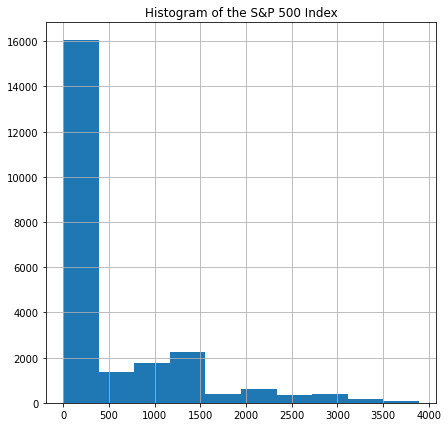

In [8]:
plt.figure(figsize=(7, 7))
plt.title("Histogram of the S&P 500 Index")
plt.hist(close)
plt.grid()
plt.savefig('image1.png')

The time series plot of the complete dataset (original series) exhibits some sort of polynomial trend for that reason the plot shows also a polynomial trend of degree 3 that later will be used to detrend the series.

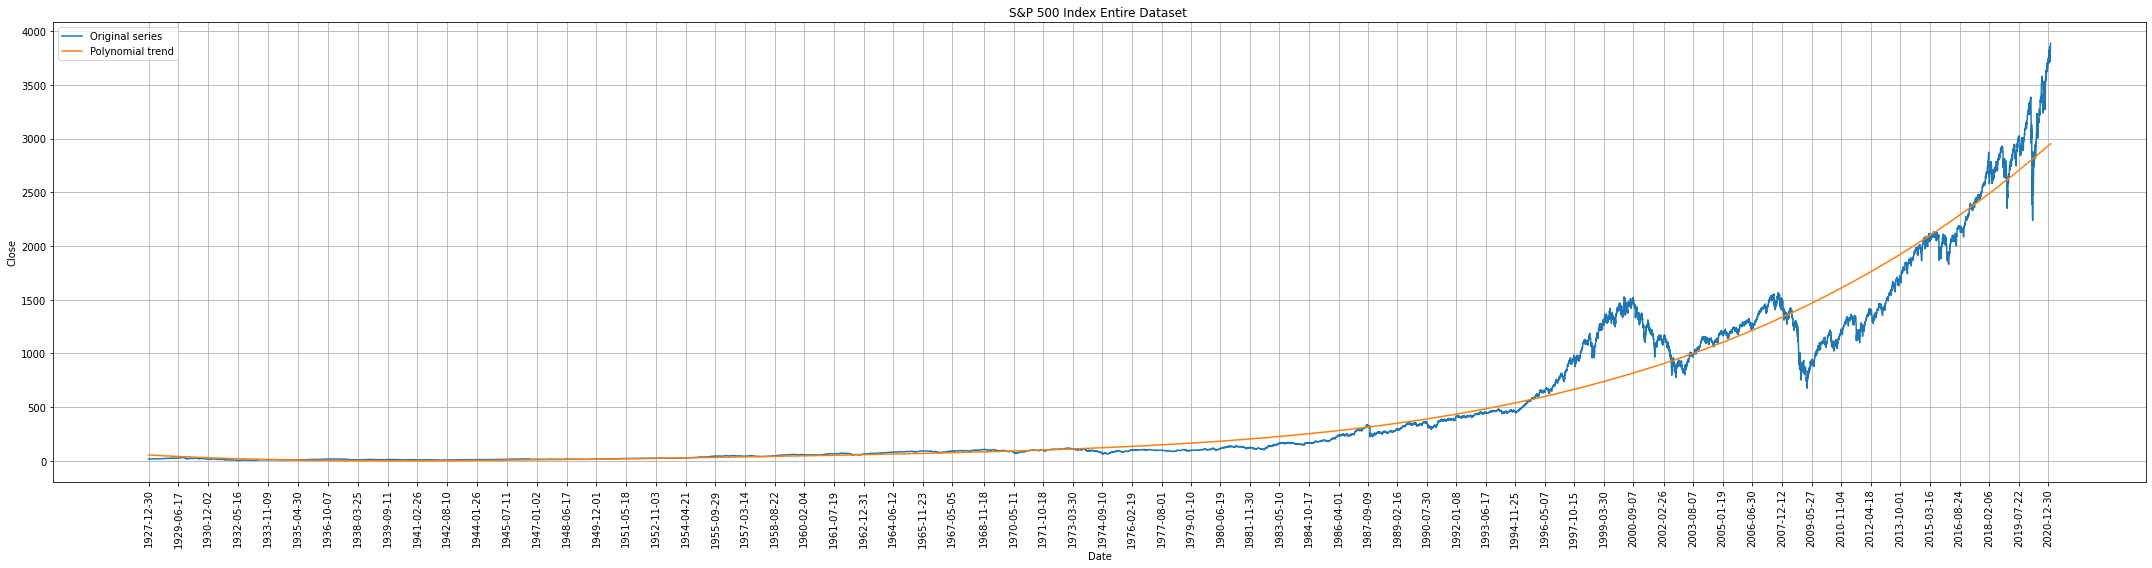

In [9]:
plt.figure(figsize=(30, 8))
plt.title("S&P 500 Index Entire Dataset ")
plot_series(np.reshape(date, (SIZE, 1)), np.reshape(close, (SIZE, 1)), start=0, end=SIZE, ticks=365, y_label="Close")
plot_series(np.reshape(date, (SIZE, 1)), np.reshape(trend_pred, (SIZE, 1)), start=0, end=SIZE, label="Polynomial trend", ticks=365, y_label="Close")
plt.savefig('image2.png')

Descriptive statistics of the complete S&P 500 daily close dataset detrended and rescaled.

In [10]:
detrended_standard_df = pd.DataFrame(close_standard, index=date, columns=["close"])
detrended_standard_df.describe()

,close
count,2.338600e+04
mean,-2.305709e-16
std,1.000021e+00
min,-4.578688e+00
25%,-2.584800e-01
50%,8.681351e-03
75%,7.009742e-02
max,5.565548e+00


The histogram of the complete data set (detrended and rescaled series) does not look skewed but has a high peak around the mean with occasional values far from the mean which suggest a high kurtosis. However, it looks better for training a machine learning model than the original data histogram.

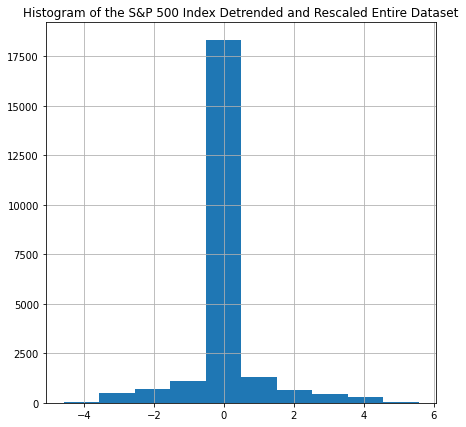

In [11]:
plt.figure(figsize=(7, 7))
plt.title("Histogram of the S&P 500 Index Detrended and Rescaled Entire Dataset")
plt.hist(close_standard)
plt.grid()
plt.savefig('image3.png')

The time series plot of the complete dataset (detrended and rescaled) does not exhibits any sort of deterministic trend. Below will be tested for a unit root or in other words a stochastic trend. 

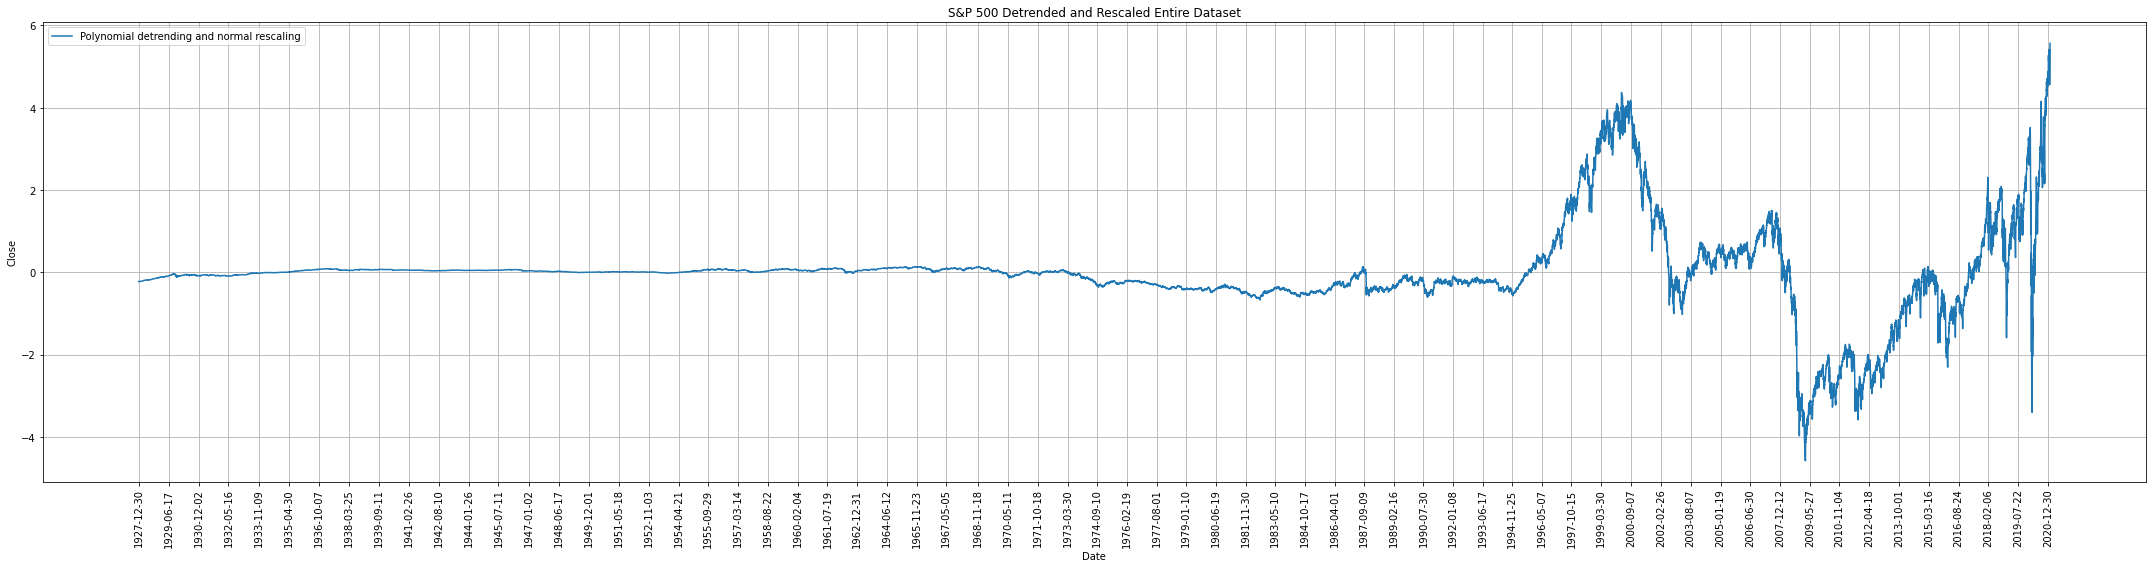

In [12]:
plt.figure(figsize=(30, 8))
plt.title("S&P 500 Detrended and Rescaled Entire Dataset")
plot_series(np.reshape(date, (SIZE, 1)), np.reshape(close_standard, (SIZE, 1)), start=0, end=SIZE, label="Polynomial detrending and normal rescaling", ticks=365, y_label="Close")
plt.savefig('image4.png')

### Unit root test and autocorrelogram of the detrended rescaled series.

As can be seen below, the results of the unit root tests are conflicting however currently the KPSS test is considered better than the ADF test. 

Furthermore, the autocorrelogram suggest strong autocorrelation in the series which could be a sign of the existence of a stochastic trend but in any case none of the methods that will be used subsequently, which are highly non linear, requeries stationarity of the series (or which is the same the non exitence of a unit root).

The Augmented Dickie Fuller (ADF) test cannot reject the null hypothesis of a unit root in the time series at a 10 percent confidence level. In other words the test suggest that the series exhibits a stochastic trend.

In [13]:
# ADF Test
result = adfuller(detrended_standard_df.close.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.708320797130697
p-value: 0.4268305316272373
Critial Values:
   1%, -3.430630230499699
Critial Values:
   5%, -2.861663853007729
Critial Values:
   10%, -2.566835923402247


The Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test cannot reject the null hypothesis of the non existence of a unit root at the 10 percent level. In other words the test suggest that the series does not exhibits a stochastic trend.

In [14]:
# KPSS Test
result = kpss(detrended_standard_df.close.values, regression='c', lags='auto')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


KPSS Statistic: 0.354771
p-value: 0.096650
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


The autocorrelogram suggest strong autocorrelation in the series which could be a sign of the existence of a stochastic trend.

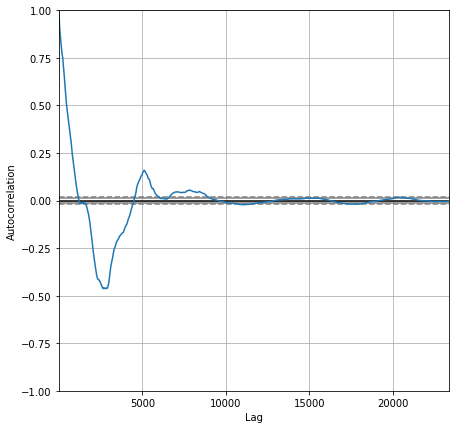

In [15]:
plt.rcParams.update({'figure.figsize':(7,7)})
pd.plotting.autocorrelation_plot(detrended_standard_df)
plt.savefig('image5.png')

Separating the data in training and a validation datasets.

In [16]:
def get_train_length(dataset, test_percent, batch_size=BATCH_SIZE):
  # substract test_percent to be excluded from training, reserved for testset
  length = len(dataset)
  length *= 1 - test_percent
  train_length_values = []
  
  for x in range(int(length) - 100, int(length)): # 100 in order to assure the maximum lenght is found
      modulo=x%batch_size
      if (modulo == 0):
          train_length_values.append(x)
  
  return (max(train_length_values))

def get_valid_length(dataset, batch_size=BATCH_SIZE, window_size=WINDOW_SIZE):
  test_length_values = []
  
  for x in range(len(dataset) - 200, len(dataset) - window_size*2): # 200 in order to assure the maximum lenght is found
    modulo=(x-UPPER_TRAIN)%batch_size
    if (modulo == 0):
      test_length_values.append(x)
  
  return (max(test_length_values))

# Finding the end of the train set or the start of the validation set

SPLIT_TIME_START = get_train_length(close, test_percent=0.05)

# Adding window_size * 2 observations to the end of the train set in order to get all arrays divisible by 64

UPPER_TRAIN = SPLIT_TIME_START + WINDOW_SIZE*2

# Finding the end of the t set

SPLIT_TIME_END = get_valid_length(close)

# Adding window_size * 2 observations to the end of the test set in order to get all arrays divisible by 64

UPPER_VALID = SPLIT_TIME_END + WINDOW_SIZE*2
VALID_LENGTH = SPLIT_TIME_END - UPPER_TRAIN 
 

SP_500_train = close_standard[0:UPPER_TRAIN]
SP_500_valid = close_standard[UPPER_TRAIN:UPPER_VALID]

# Split chosen that data is compatible with batches of 64

Date_train = date[0:UPPER_TRAIN]
Date_train = np.reshape(Date_train, (UPPER_TRAIN,1))
X_train_1 = SP_500_train
X_train_2 = close[0:UPPER_TRAIN]
Date_valid = date[UPPER_TRAIN:UPPER_VALID]
Date_valid = np.reshape(Date_valid, (VALID_LENGTH + WINDOW_SIZE*2,1))
X_valid_1 = SP_500_valid
X_valid_2 = close[UPPER_TRAIN:UPPER_VALID]

print("Shape of the training date series: ", Date_train.shape)
print("Shape of the training standardaized close series: ", X_train_1.shape)
print("Shape of the validation date series: ", Date_valid.shape)
print("Shape of the validation standardaized close series: ", X_valid_1.shape)

Shape of the training date series:  (22268, 1)
Shape of the training standardaized close series:  (22268, 1)
Shape of the validation date series:  (1084, 1)
Shape of the validation standardaized close series:  (1084, 1)


Time series plot of the validation dataset (original series) exhibits a deterministic trend.

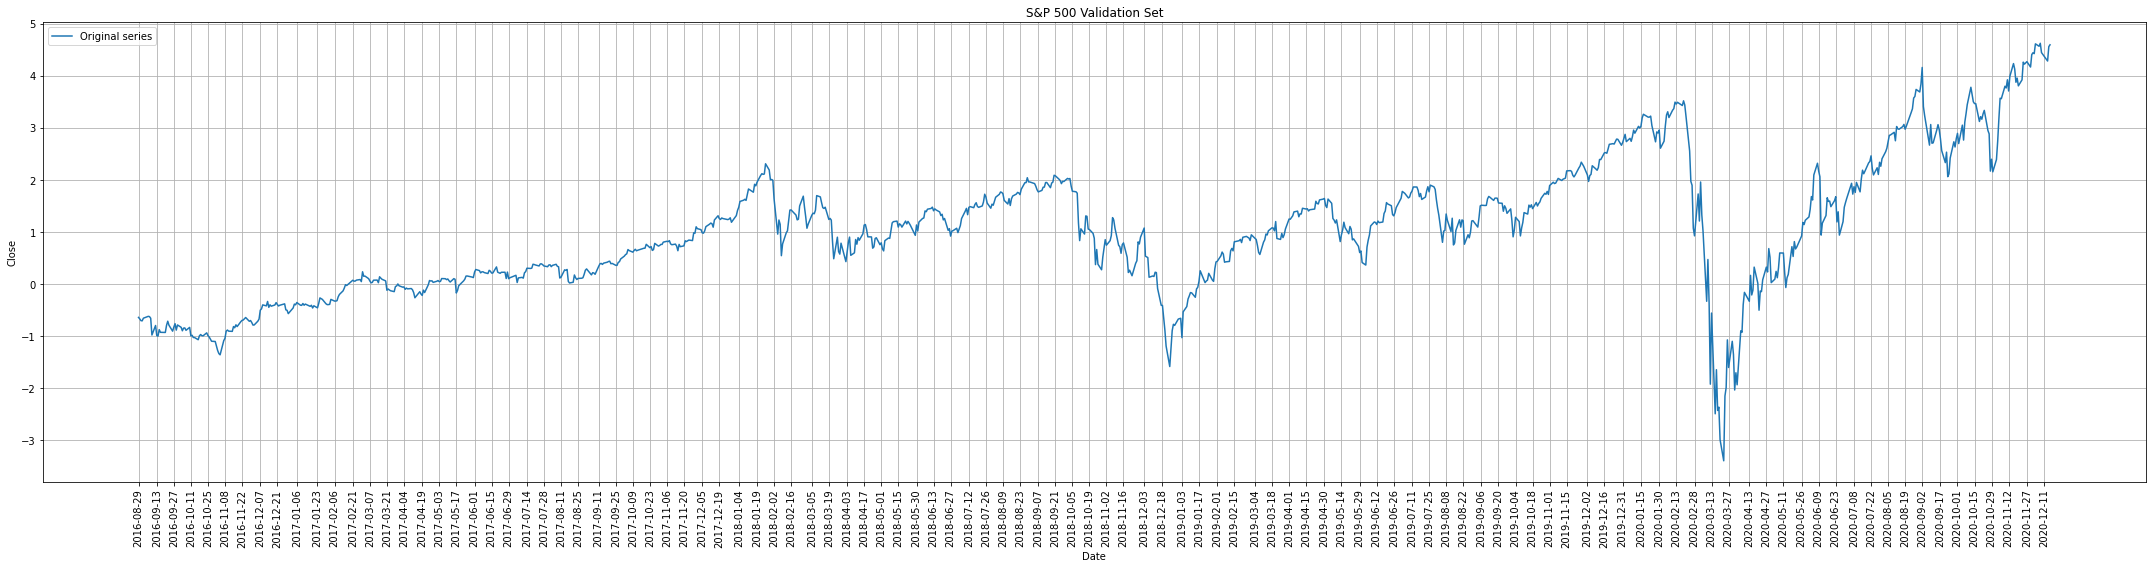

In [17]:
plt.figure(figsize=(30, 8))
plt.title("S&P 500 Validation Set")
plot_series(Date_valid, X_valid_1, start=0, ticks=10, y_label="Close")
plt.savefig('image6.png')

## Non Deep Learning (Baseline) Method, Dense Neural Network Model Estimation and Forecasting.

The data is separated in batches and shuffled for generalization of the model.

In [18]:
def windowed_dataset_dense(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE, shuffle_buffer=SHUFFLE_BUFFER_SIZE): 
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) 
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1) 
  return dataset
  
dataset_train = windowed_dataset_dense(np.reshape(X_train_1, -1))
dataset_val = windowed_dataset_dense(np.reshape(X_valid_1, -1))

Three layer artificial neural network with 40 relu activations units in the firs layer, 30 in the second layer and 20 in the third layer.

In [19]:
model_1 = tf.keras.models.Sequential([ 
tf.keras.layers.Dense(40, input_shape=[None,1], activation="relu"), 
tf.keras.layers.Dense(30, activation="relu"),
tf.keras.layers.Dense(20, activation="relu"),
tf.keras.layers.Dense(1)])
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, None, 40)          80        
_________________________________________________________________
dense_1 (Dense)              (None, None, 30)          1230      
_________________________________________________________________
dense_2 (Dense)              (None, None, 20)          620       
_________________________________________________________________
dense_3 (Dense)              (None, None, 1)           21        
Total params: 1,951
Trainable params: 1,951
Non-trainable params: 0
_________________________________________________________________


The Huber loss is chosen because it is quite robust for non linear regression models and models with non normal errors.

In [20]:
optimizer = tf.keras.optimizers.RMSprop()
model_1.compile(loss='huber_loss', optimizer=optimizer)
history = model_1.fit(dataset_train, epochs=EPOCHS, validation_data=dataset_val, verbose=1)

Epoch 1/100
348/348 [==============================] - 4s 10ms/step - loss: 0.0024 - val_loss: 0.2187
Epoch 2/100
348/348 [==============================] - 3s 8ms/step - loss: 0.0015 - val_loss: 0.2360
Epoch 3/100
348/348 [==============================] - 3s 9ms/step - loss: 0.0016 - val_loss: 0.2256
Epoch 4/100
348/348 [==============================] - 3s 9ms/step - loss: 0.0016 - val_loss: 0.2358
Epoch 5/100
348/348 [==============================] - 3s 9ms/step - loss: 0.0016 - val_loss: 0.2150
Epoch 6/100
348/348 [==============================] - 3s 9ms/step - loss: 0.0015 - val_loss: 0.2242
Epoch 7/100
348/348 [==============================] - 3s 9ms/step - loss: 0.0015 - val_loss: 0.2451
Epoch 8/100
348/348 [==============================] - 3s 9ms/step - loss: 0.0015 - val_loss: 0.2139
Epoch 9/100
348/348 [==============================] - 3s 9ms/step - loss: 0.0014 - val_loss: 0.2100
Epoch 10/100
348/348 [==============================] - 3s 9ms/step - loss: 0.0014 - val_l

In [21]:
def model_forecast_1(model, series, window_size):
  series = tf.convert_to_tensor(series, dtype=tf.float32)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True) 
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(BATCH_SIZE).prefetch(1)
  forecast = model.predict(ds)
  return forecast

forecast_1 = model_forecast_1(model_1, np.reshape(X_valid_1, -1), WINDOW_SIZE)
forecast_1 = standard_scaler.inverse_transform(forecast_1)
forecast_1 = forecast_1[1:UPPER_VALID - WINDOW_SIZE,-1,-1] + trend_pred[UPPER_TRAIN:UPPER_VALID - WINDOW_SIZE]
forecast_1 = np.reshape(forecast_1, (VALID_LENGTH + WINDOW_SIZE, 1))

The baseline method exhibits very good fit with respect to the validation set.

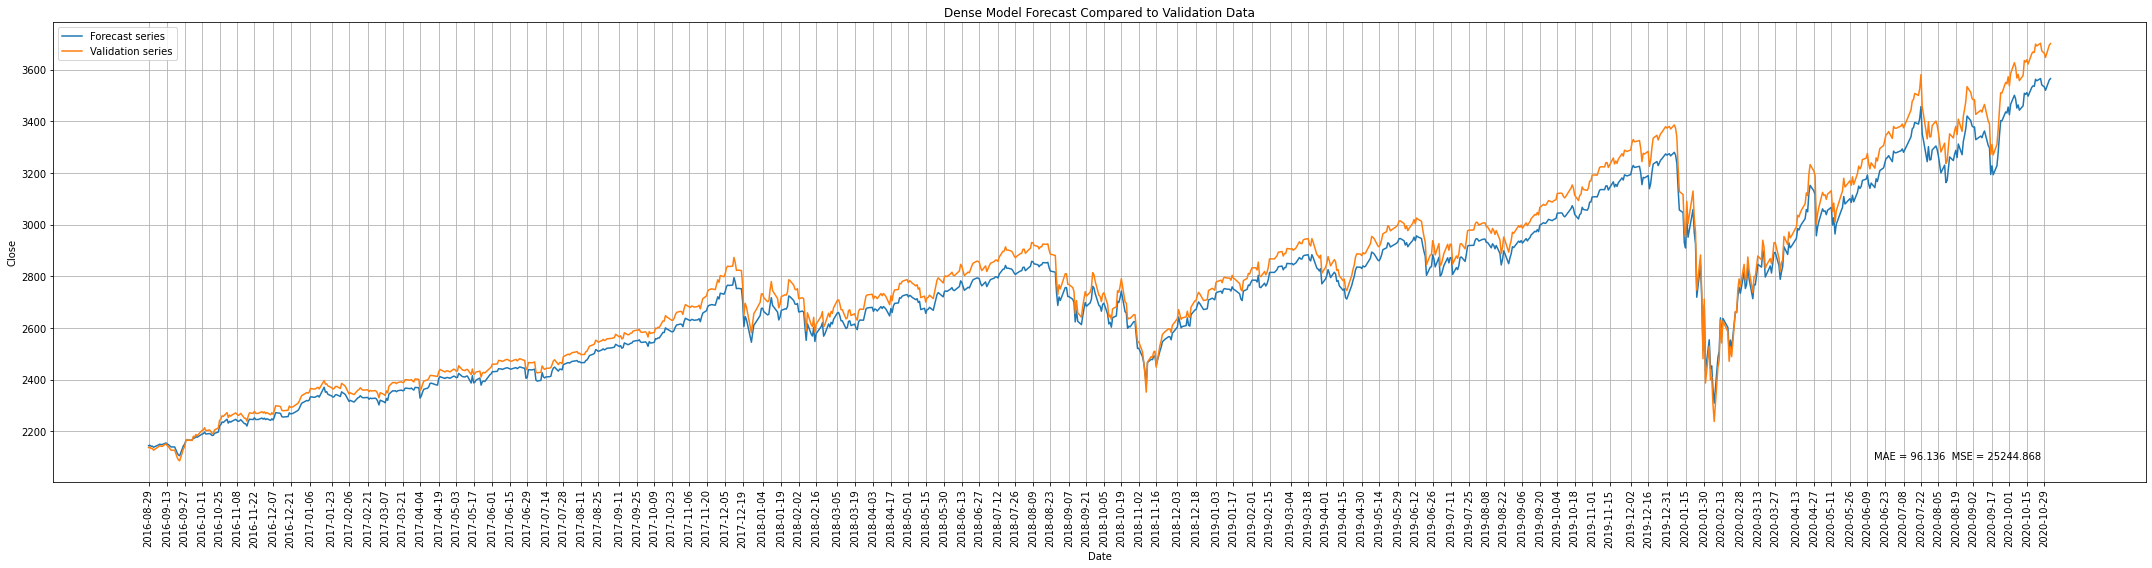

In [22]:
plt.figure(figsize=(30, 8))
plt.title("Dense Model Forecast Compared to Validation Data")
plot_series(Date_valid[:VALID_LENGTH + WINDOW_SIZE], forecast_1, start=0, label="Forecast series",  y_label="", ticks=10)
plot_series(Date_valid[:VALID_LENGTH + WINDOW_SIZE], np.reshape(X_valid_2[WINDOW_SIZE:VALID_LENGTH + WINDOW_SIZE*2], (VALID_LENGTH + WINDOW_SIZE , 1)), start=0, label="Validation series", y_label="Close", ticks=10)

MAE = tf.keras.metrics.mean_absolute_error(X_valid_2[:VALID_LENGTH + WINDOW_SIZE], forecast_1[:,-1]).numpy()
MSE = tf.keras.metrics.mean_squared_error(X_valid_2[:VALID_LENGTH + WINDOW_SIZE], forecast_1[:,-1]).numpy()

textstr = "MAE = " + "{:.3f}".format(MAE) + "  MSE = " + "{:.3f}".format(MSE)

# place a text box in upper left in axes coords
plt.annotate(textstr, xy=(0.87, 0.05), xycoords='axes fraction')
plt.savefig('image7.png')


##Deep Learning Methods, Stateless Versus Stateful LSTM.

Stateless: LSTM updates parameters on batch 1 (which is shuffleld) and then initiates cell states (meaning - memory, usually with zeros) for batch 2 (which is also shuffleld).

Stateful: it uses batch 1 last output cell sates as initial states for batch 2 to update LSTM parameters.

The expectation is that with a large enough batch size forecasting results from a statefull and a stateless LSTM should be nearly identical.

## Stateless LSTM Estimation and Forecasting.

The data is separated in batches and shuffled for generalization of the model.

In [23]:
def windowed_dataset_stateless(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE, shuffle_buffer=SHUFFLE_BUFFER_SIZE): 
  series = tf.convert_to_tensor(series, dtype=tf.float64)
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) 
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1) 
  return dataset
  
dataset_train = windowed_dataset_stateless(np.reshape(X_train_1, -1))
dataset_val = windowed_dataset_stateless(np.reshape(X_valid_1, -1))

Three layer stateless LSTM with 40 units in the firs layer, 30 in the second layer and 20 in the third layer. Each layer has a dropout rate of 15 percent.

In [24]:
model_2 = tf.keras.models.Sequential([
tf.keras.layers.LSTM(40, input_shape=[None, 1], dropout=0.05, return_sequences=True),
tf.keras.layers.LSTM(30, dropout=0.05, return_sequences=True),
tf.keras.layers.LSTM(20, dropout=0.05),
tf.keras.layers.Dense(1)
])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 40)          6720      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 30)          8520      
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                4080      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 19,341
Trainable params: 19,341
Non-trainable params: 0
_________________________________________________________________


The Huber loss is chosen because it is quite robust for non linear regression models and models with non normal errors.

In [25]:
optimizer = tf.keras.optimizers.RMSprop()
model_2.compile(loss='huber_loss', optimizer=optimizer)
history = model_2.fit(dataset_train, epochs=EPOCHS, validation_data=dataset_val, verbose=1)

Epoch 1/100
348/348 [==============================] - 10s 14ms/step - loss: 0.0040 - val_loss: 0.2294
Epoch 2/100
348/348 [==============================] - 4s 11ms/step - loss: 0.0019 - val_loss: 0.1477
Epoch 3/100
348/348 [==============================] - 4s 12ms/step - loss: 0.0014 - val_loss: 0.1199
Epoch 4/100
348/348 [==============================] - 4s 11ms/step - loss: 0.0013 - val_loss: 0.0902
Epoch 5/100
348/348 [==============================] - 4s 11ms/step - loss: 0.0012 - val_loss: 0.0777
Epoch 6/100
348/348 [==============================] - 4s 11ms/step - loss: 0.0011 - val_loss: 0.0752
Epoch 7/100
348/348 [==============================] - 4s 12ms/step - loss: 0.0011 - val_loss: 0.0686
Epoch 8/100
348/348 [==============================] - 4s 11ms/step - loss: 0.0011 - val_loss: 0.0633
Epoch 9/100
348/348 [==============================] - 4s 12ms/step - loss: 9.8364e-04 - val_loss: 0.0635
Epoch 10/100
348/348 [==============================] - 4s 12ms/step - loss: 

In [26]:
def model_forecast_2(model, series, window_size):
  series = tf.convert_to_tensor(series, dtype=tf.float32)
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True) 
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(BATCH_SIZE).prefetch(1)
  forecast = model.predict(ds)
  return forecast

forecast_2 = model_forecast_2(model_2, np.reshape(X_valid_1, -1), WINDOW_SIZE)
forecast_2 = standard_scaler.inverse_transform(forecast_2)
forecast_2 = forecast_2[1:UPPER_VALID - WINDOW_SIZE,-1] + trend_pred[UPPER_TRAIN:UPPER_VALID - WINDOW_SIZE]
forecast_2 = np.reshape(forecast_2, (VALID_LENGTH + WINDOW_SIZE, 1))

The stateless LSTM exhibits an almost equal fit on the test set when compared to the baseline model.

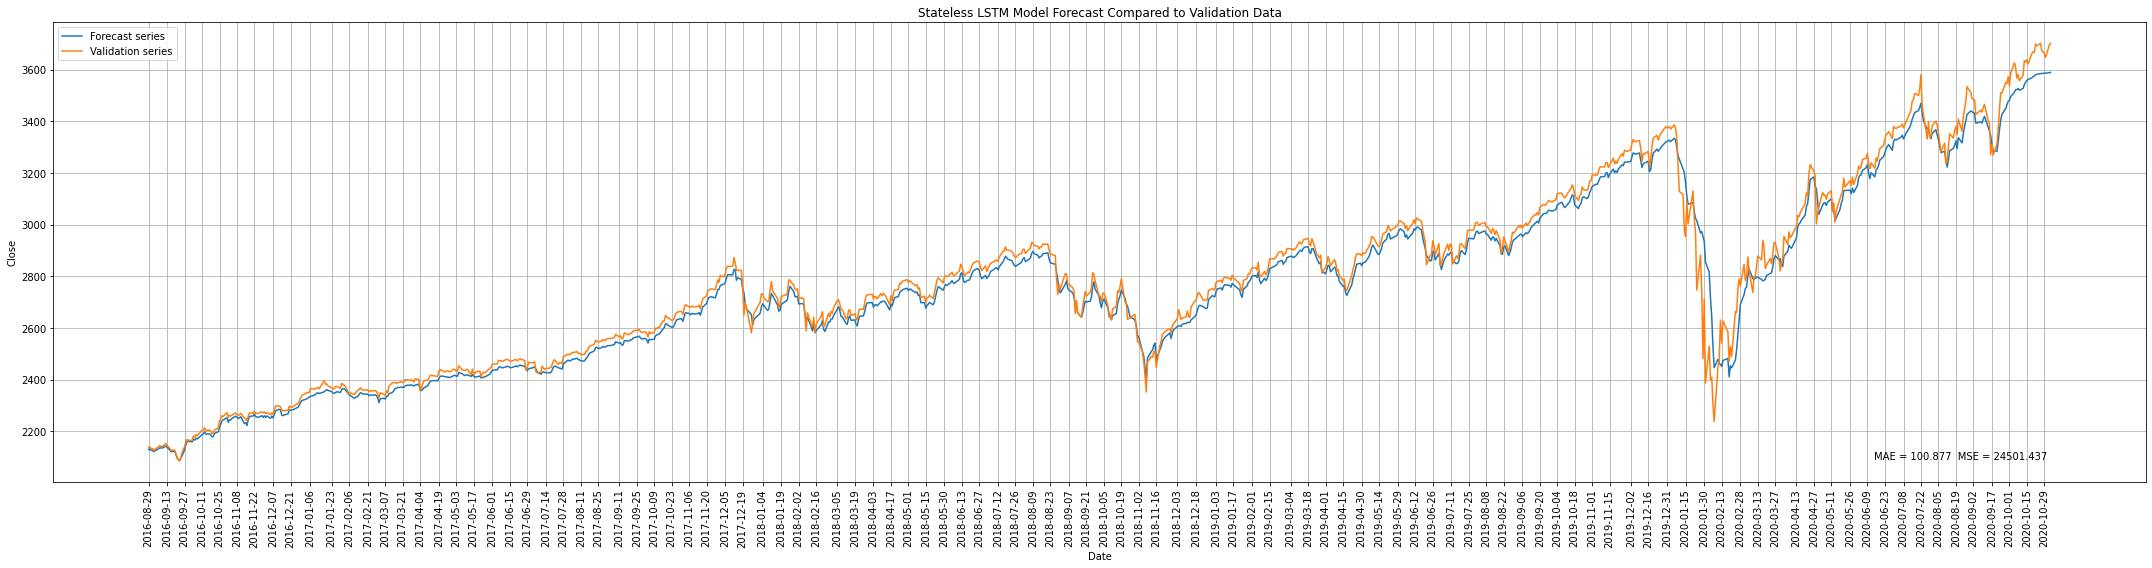

In [27]:
plt.figure(figsize=(30, 8))
plt.title("Stateless LSTM Model Forecast Compared to Validation Data")
plot_series(Date_valid[:VALID_LENGTH + WINDOW_SIZE], forecast_2, start=0, label="Forecast series",  y_label="", ticks=10)
plot_series(Date_valid[:VALID_LENGTH + WINDOW_SIZE], np.reshape(X_valid_2[WINDOW_SIZE:VALID_LENGTH + 2*WINDOW_SIZE], (VALID_LENGTH + WINDOW_SIZE , 1)), start=0, label="Validation series", y_label="Close", ticks=10)

MAE = tf.keras.metrics.mean_absolute_error(X_valid_2[:VALID_LENGTH + WINDOW_SIZE], forecast_2[:,-1]).numpy()
MSE = tf.keras.metrics.mean_squared_error(X_valid_2[:VALID_LENGTH + WINDOW_SIZE], forecast_2[:,-1]).numpy()

textstr = "MAE = " + "{:.3f}".format(MAE) + "  MSE = " + "{:.3f}".format(MSE)

# place a text box in upper left in axes coords
plt.annotate(textstr, xy=(0.87, 0.05), xycoords='axes fraction')
plt.savefig('image8.png')

## Stateful LSTM Estimation and Forecasting.

The data is separated in batches and is not shuffled as it will be used for a stateful model.

In [28]:
def windowed_train_dataset_statefull(dataset, window_size=WINDOW_SIZE, length=SPLIT_TIME_START): 
  X = []
  Y = []
  for i in range(window_size, length + window_size): 
    X.append(dataset[i-window_size:i,0])
    Y.append(dataset[i:i+window_size,0])
  return X, Y

def windowed_valid_dataset_statefull(dataset, window_size=WINDOW_SIZE, length=VALID_LENGTH): 
  X = []
  for i in range(window_size, length + window_size): 
    X.append(dataset[i-window_size:i,0])
  return X

X_train_1, Y_train_1 = windowed_train_dataset_statefull(X_train_1)
X_valid_1 = windowed_valid_dataset_statefull(X_valid_1)

X_train_1 = np.array(X_train_1)
X_valid_1 = np.array(X_valid_1)
Y_train_1 = np.array(Y_train_1)

X_train_1 = np.reshape(X_train_1, (X_train_1.shape[0], X_train_1.shape[1], 1))
X_valid_1 = np.reshape(X_valid_1, (X_valid_1.shape[0], X_valid_1.shape[1], 1))
Y_train_1 = np.reshape(Y_train_1, (Y_train_1.shape[0], Y_train_1.shape[1], 1))

print("Shape of the X train set for the stateful LSTM: ", X_train_1.shape)
print("Shape of the Y train set for the stateful LSTM: ", Y_train_1.shape)
print("Shape of the X validation set for the stateful LSTM: ", X_valid_1.shape)

Shape of the X train set for the stateful LSTM:  (22208, 30, 1)
Shape of the Y train set for the stateful LSTM:  (22208, 30, 1)
Shape of the X validation set for the stateful LSTM:  (1024, 30, 1)


Three layer stateful LSTM with 40 units in the firs layer, 30 in the second layer and 20 in the third layer. No dropout is used.

In [29]:
model_3 = tf.keras.models.Sequential([
tf.keras.layers.Input(batch_shape=(BATCH_SIZE, WINDOW_SIZE, 1)),
tf.keras.layers.LSTM(40, stateful=True, return_sequences=True), 
tf.keras.layers.LSTM(30, stateful=True, return_sequences=True),
tf.keras.layers.LSTM(20, stateful=True, return_sequences=True),
tf.keras.layers.Dense(1)
])
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (64, 30, 40)              6720      
_________________________________________________________________
lstm_4 (LSTM)                (64, 30, 30)              8520      
_________________________________________________________________
lstm_5 (LSTM)                (64, 30, 20)              4080      
_________________________________________________________________
dense_5 (Dense)              (64, 30, 1)               21        
Total params: 19,341
Trainable params: 19,341
Non-trainable params: 0
_________________________________________________________________


The Huber loss is chosen because it is quite robust for non linear regression models and models with non normal errors.

In [30]:
optimizer = tf.keras.optimizers.RMSprop()
model_3.compile(loss='huber_loss', optimizer=optimizer)

for i in range(EPOCHS):
    print("Epoch: " + str(i))
    model_3.fit(X_train_1, Y_train_1, batch_size=BATCH_SIZE, epochs=1, shuffle=False, verbose=1)
    model_3.reset_states()

Epoch: 0
347/347 [==============================] - 6s 8ms/step - loss: 0.0085
Epoch: 1
347/347 [==============================] - 3s 8ms/step - loss: 0.0449
Epoch: 2
347/347 [==============================] - 3s 8ms/step - loss: 0.0380
Epoch: 3
347/347 [==============================] - 3s 8ms/step - loss: 0.0340
Epoch: 4
347/347 [==============================] - 3s 8ms/step - loss: 0.0325
Epoch: 5
347/347 [==============================] - 3s 8ms/step - loss: 0.0311
Epoch: 6
347/347 [==============================] - 3s 8ms/step - loss: 0.0298
Epoch: 7
347/347 [==============================] - 3s 8ms/step - loss: 0.0290
Epoch: 8
347/347 [==============================] - 3s 8ms/step - loss: 0.0291
Epoch: 9
347/347 [==============================] - 3s 8ms/step - loss: 0.0272
Epoch: 10
347/347 [==============================] - 3s 8ms/step - loss: 0.0277
Epoch: 11
347/347 [==============================] - 3s 8ms/step - loss: 0.0271
Epoch: 12
347/347 [==============================]

In [31]:
def model_forecast_3(model, series, batch_size=BATCH_SIZE, window_size=WINDOW_SIZE):
  forecast_3 = model.predict(series, batch_size=batch_size)
  model.reset_states()
  forecast_3 = np.reshape(forecast_3, (forecast_3.shape[0], forecast_3.shape[1]))
  return forecast_3

def create_Y_valid(series, valid_length=VALID_LENGTH, window_size=WINDOW_SIZE):
  Y = []
  for j in range(0, valid_length - window_size):
    Y = np.append(Y, series[j, window_size-1])
  Y_1 = np.reshape(Y, (Y.shape[0], 1))
  return Y_1

forecast_3 = model_forecast_3(model_3, X_valid_1)
forecast_3 = create_Y_valid(forecast_3)
forecast_3 = standard_scaler.inverse_transform(forecast_3)
forecast_3 = forecast_3[1:UPPER_VALID - WINDOW_SIZE,-1] + trend_pred[UPPER_TRAIN:UPPER_VALID - 3*WINDOW_SIZE -1]
forecast_3 = np.reshape(forecast_3, (UPPER_VALID - UPPER_TRAIN - 3*WINDOW_SIZE -1, 1))

The stateful LSTM exhibits a better fit on the validation set when compared to the baseline model and the stateless LSTM with shuffling.

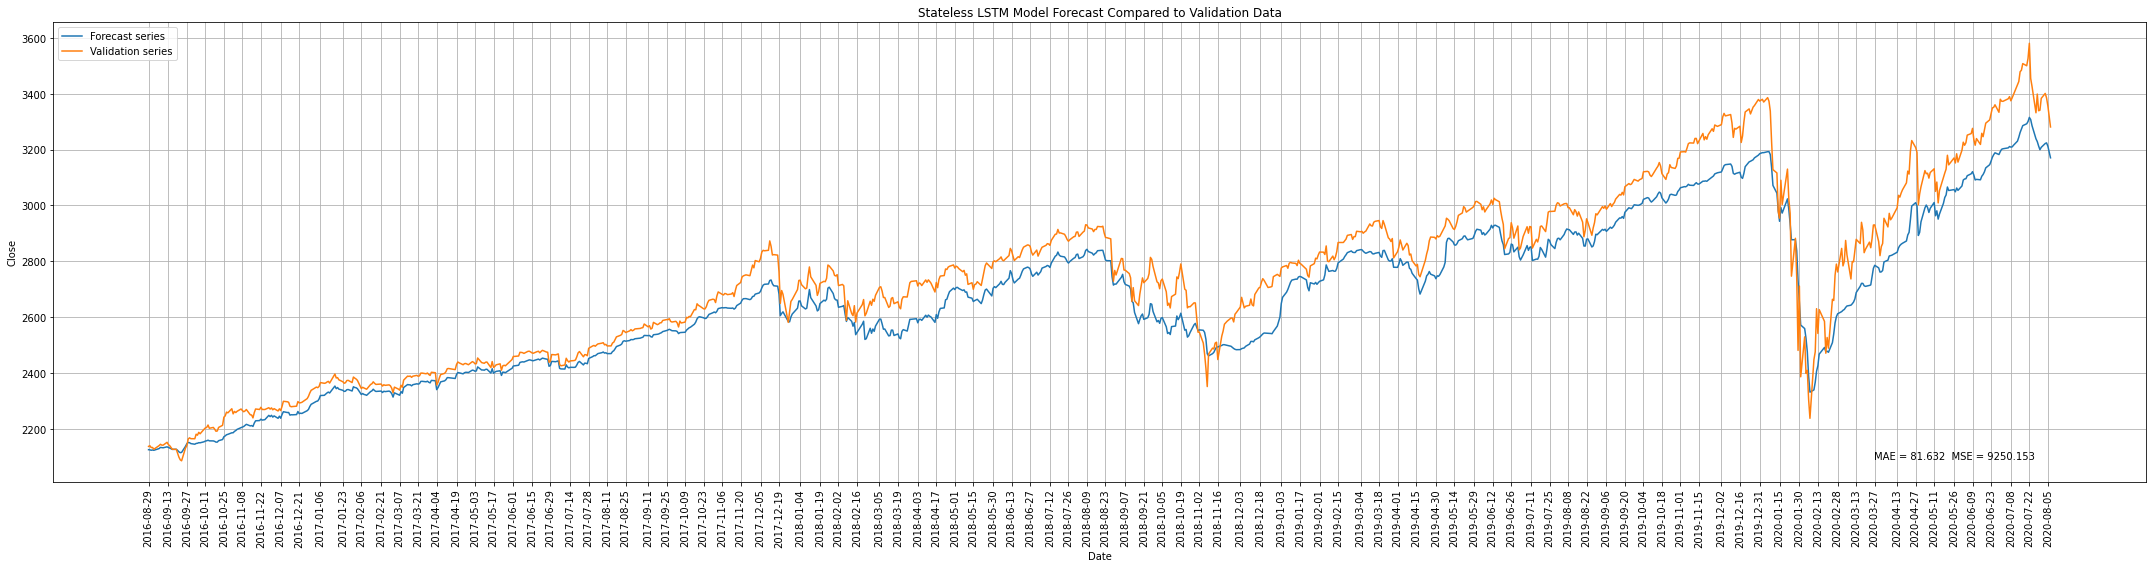

In [32]:
plt.figure(figsize=(30, 8))
plt.title("Stateless LSTM Model Forecast Compared to Validation Data")
plot_series(Date_valid[:VALID_LENGTH - WINDOW_SIZE -1], forecast_3, start=0, label="Forecast series",  y_label="", ticks=10)
plot_series(Date_valid[:VALID_LENGTH - WINDOW_SIZE -1], np.reshape(X_valid_2[WINDOW_SIZE:VALID_LENGTH -1], (VALID_LENGTH - WINDOW_SIZE - 1, 1)), start=0, label="Validation series", y_label="Close", ticks=10)

MAE = tf.keras.metrics.mean_absolute_error(X_valid_2[WINDOW_SIZE:VALID_LENGTH -1], forecast_3[:,-1]).numpy()
MSE = tf.keras.metrics.mean_squared_error(X_valid_2[WINDOW_SIZE:VALID_LENGTH -1], forecast_3[:,-1]).numpy()

textstr = "MAE = " + "{:.3f}".format(MAE) + "  MSE = " + "{:.3f}".format(MSE)

# place a text box in upper left in axes coords
plt.annotate(textstr, xy=(0.87, 0.05), xycoords='axes fraction')
plt.savefig('image9.png')